# Inferential Statistics Cheat Sheet
> *Posted on March 10, 2018*

<img src="img/statistics.png" style="float:left;max-height:300px">

This is a cheat sheet for making statistical inferences on datasets. Written in Python, it makes use of libraries numpy, pandas, scipy and matplotlib.

---

## Contents

1. **Central Limit Theorem**
2. **Significancy tests**
3. **Analysis of variance (ANOVA)**
4. **Correlation**
---

In [2]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## 1. Central Limit Theorem

### Four functions
We define four functions: a logit, a Gauss, a discontinuous 'winner' and a sine function. The idea is to sample data that is distributed according to these curves. 

In [3]:
# FUNCTION 1
def logit(x, position = 0.5, spread = -20, setoff = 0, altitude = 1):
    return (1/(1+np.exp(spread * (x - position)))) * altitude + setoff

# FUNCTION 2
def gauss(x, position = 0.5, deviation = 0.1, height = 0, altitude = 1):
    return (np.exp(-np.square(x - position) / (2 * np.square(deviation))) + height) * altitude

# FUNCTION 3
def winner(x, position = None):
    xPoints = np.linspace(0, 1, 5)
    yPoints = [1, 0, 0.5, 0, 1]
    h = interp1d(xPoints, yPoints)
    return h(x)

# FUNCTION 4
def sine(x, position = 0.5):
    return (np.sin(10*x + position))*0.5+0.5

functions = [logit, gauss, winner, sine]

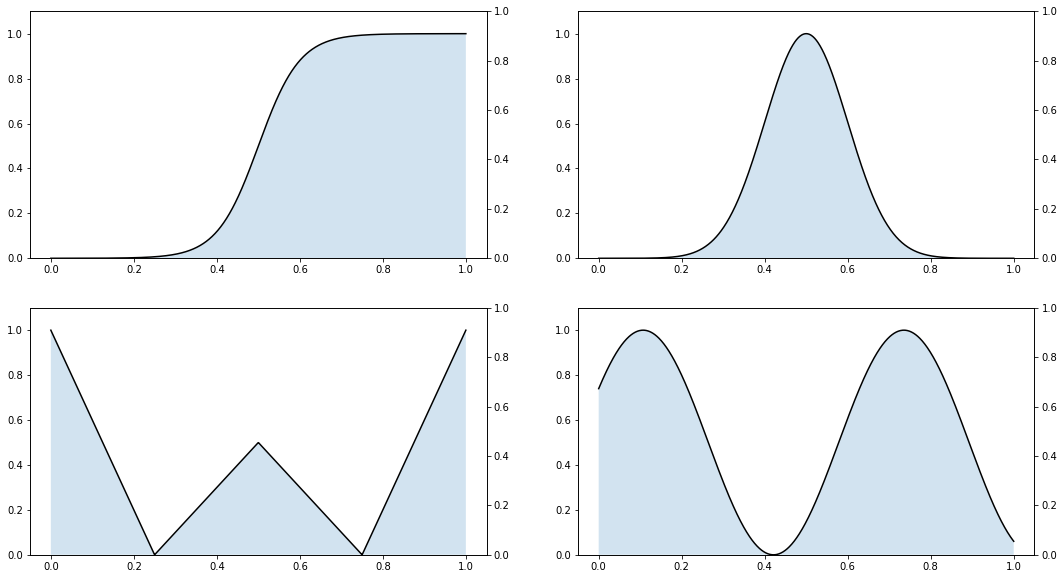

In [5]:
x = np.linspace(0, 1, num=1000)
fig = plt.figure(figsize=(18, 10))
for i, f in enumerate(functions):
    ax = fig.add_subplot(221+i); ax2 = ax.twinx()
    ax.plot(x, f(x), '-k'); ax.set_ylim(0,1.1)
    ax.fill_between(x, 0, f(x), alpha=0.2)
plt.show()

### Population Distribution
Now we sample 1000 numbers between 0 and 1 in a way that their distributions follow the curves above. We can do so with this function.

In [3]:
def generateDistribution(function, size=1):
    if size==1:
        x = np.random.rand()
        y = function(x)
        if np.random.rand() <= y: return x
        return generateDistribution(function)
    else: return np.array([generateDistribution(function) for _ in range(size)])

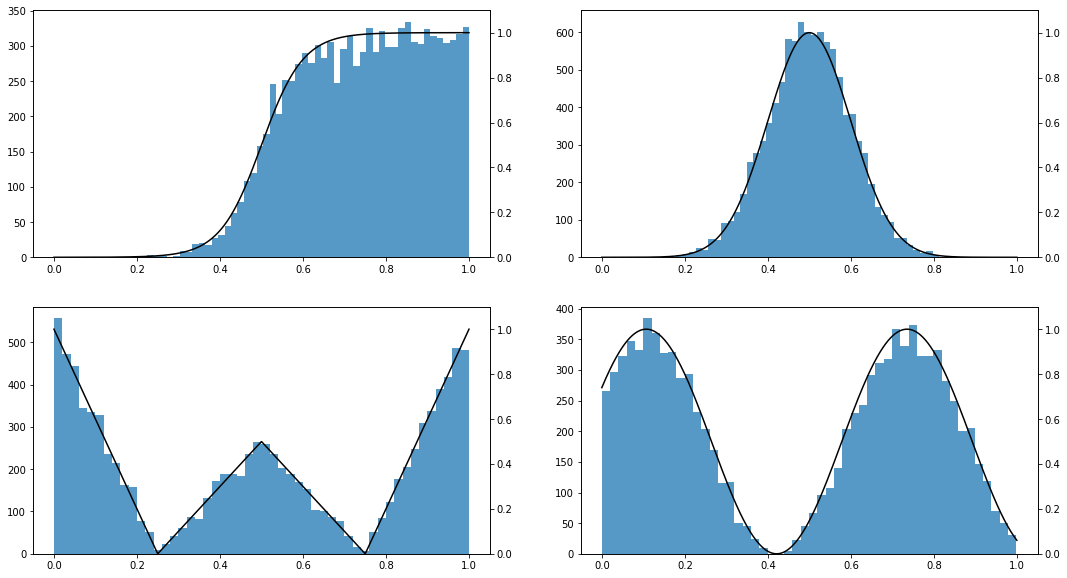

In [4]:
x = np.linspace(0, 1, num=1000)
fig = plt.figure(figsize=(18, 10))
mean, sd = [], []
for i, f in enumerate(functions):
    ax = fig.add_subplot(221+i); ax2 = ax.twinx()
    population = generateDistribution(f, 10000)
    ax.hist(population, bins=50, alpha=0.75)
    mean.append(population.mean())
    sd.append(np.std(population))
    ax2.plot(x, f(x), '-k'); ax2.set_ylim(0,1.1)
plt.show()

### Sampling Distribution
If we take 10k of these samples, but with only 5 datapoints each, their means are always follow a normal distribution. This is the Central Limit Theorem.

In [5]:
SIZE = 5
SAMPLES = 10000
ZSCORE = 1.96

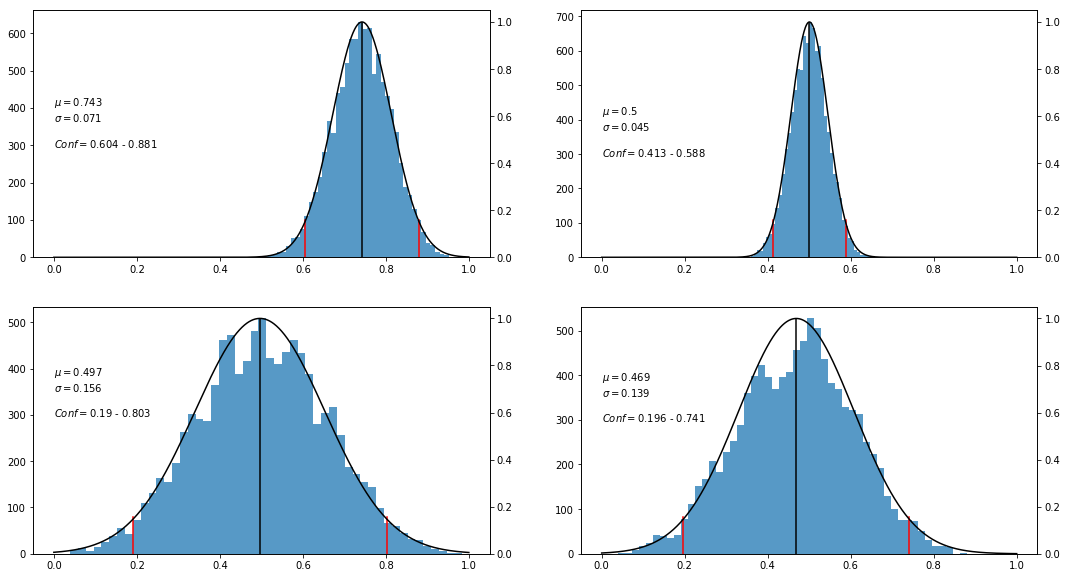

In [6]:
x = np.linspace(0, 1, num=1000)
fig = plt.figure(figsize=(18, 10))
for i, f in enumerate(functions):
    ax = fig.add_subplot(221+i); ax2 = ax.twinx()
    
    samplemeans = [generateDistribution(f, SIZE).mean() for _ in range(SAMPLES)]
    se = sd[i] / np.sqrt(SIZE)
    ci = (mean[i]-ZSCORE*se, mean[i]+ZSCORE*se) # = norm.interval(0.95, mean[i], se)
    
    ax.hist(samplemeans, bins=50, alpha=0.75)
    ax2.plot(x, gauss(x, mean[i], se), '-k'); ax2.set_ylim(0,)
    ax.text(0, 300, r'$\mu =$' + str(round(mean[i], 3)) + '\n' + r'$\sigma =$' + str(round(se, 3)) +
            '\n\n' + r'$Conf = $' + str(round(ci[0], 3)) + ' - ' + str(round(ci[1], 3)))
    
    ax.axvline(x=ci[0], color='r', ymax=0.15)
    ax.axvline(x=ci[1], color='r', ymax=0.15)
    ax.axvline(x=mean[i], color='k', ymax=0.95)
plt.show()

## 2. Significancy tests

In [7]:
from scipy.stats import norm, t, f, ttest_1samp, ttest_rel, ttest_ind, zscore

### Percentage tables

<img src="img/z-table.jpg" style="width:530px;display:inline-block;"/>
<img src="img/t-table.jpg" style="width:370px;display:inline-block;vertical-align:top"/>

Z-scores

In [8]:
ZSCORE = 1.96
print('Get Z-score from p-statistic: ', norm.ppf(.975))
print('Get p-statistic from Z-score: ', norm.cdf(ZSCORE), norm.sf(ZSCORE))
print()
print('Get CI from p-statistic: ', norm.interval(0.95))

Get Z-score from p-statistic:  1.95996398454
Get p-statistic from Z-score:  0.975002104852 0.0249978951482

Get CI from p-statistic:  (-1.959963984540054, 1.959963984540054)


P-scores

In [9]:
TSCORE = 1.65
DF = 999
print('Get T-score from p-statistic: ', t.ppf(.95, DF))
print('Get p-statistic from T-score: ', t.cdf(TSCORE, DF), t.sf(TSCORE, DF))
print()
print('Get CI/critical values from p-statistic: ', t.interval(0.95, DF))

Get T-score from p-statistic:  1.64638034543
Get p-statistic from T-score:  0.950371357874 0.0496286421255

Get CI/critical values from p-statistic:  (-1.9623414611334487, 1.9623414611334487)


### Helper functions

In [10]:
def plotGauss(mu0, se, cv, mean, title, apa=''):
    fig = plt.figure(figsize=(9, 5))
    x = np.linspace(mu0 - 4*se, mu0 + 4*se, num=1000)
    plt.plot(x, gauss(x, mu0, se), '-k'); plt.ylim(0,1.2)
    #plt.fill_between(x, 0, gauss(x, mu0, se), alpha=0.2)
    
    # Sample mean
    plt.axvline(x=mean, color='r', ymax=gauss(mean, mu0, se)*0.83)
    plt.text(mean, gauss(mean, mu0, se)+.1, r'$\overline{x} =$' + str(round(mean, 3)))

    # Critical values
    ci = mu0 + cv * se
    plt.fill_between(x, 0, gauss(x, mu0, se), where=x<ci[0], color='r')
    plt.text(ci.item(0), 0.23, r'$cv =$' + str(round(ci.item(0), 3)))
    if ci.size == 2:
        plt.fill_between(x, 0, gauss(x, mu0, se), where=x>ci[1], color='r')
        plt.text(ci[1], 0.23, r'$cv =$' + str(round(ci[1], 3)))    
    
    # Standard errors
    for i in np.linspace(-3, 3, 7):
        plt.axvline(i*se+mu0, color='k', ymax=gauss(i*se+mu0, mu0, se)*0.83)
    
    plt.text(mu0, 1.1, r'$\mu_0 =$' + str(round(mu0, 3)))
    plt.text(mu0+se, 0.68, r'$\sigma =$' + str(round(se, 3)))
    plt.text(mu0+(-4*se), 0.9, apa)

    plt.title(title)
    plt.show()
    
def apa(df, T, p, kind):
    s = 't('+ str(df)+') = ' + str(round(T, 2))
    s += ', p = ' + str(round(p, 2)) + ', ' + kind
    return s

### One-sampled Z-test
Is there a significant difference between a sample and a given population distribution.

\begin{align} 
\overline{x} &= \frac{1}{n} \sum^n_{i=1}{x_i}\\
z &= \frac{  {\overline{x} - \mu_0}}{{\sigma}}
\end{align}

In [11]:
# Descriptive statistics
sample = norm.rvs(loc=7, scale=2, size=10)
mean = np.mean(sample)
mu0, sigma = 8, 2
print(mean)
print(sample)

7.39956764833
[  5.35874324  10.11655357   7.55455653   5.86152635   6.74013667
   7.1548175    9.52027486   8.40396362   8.84419321   4.44091092]


In [12]:
# Inferential statistics
Z = (mean - mu0) / sigma
p = norm.cdf(Z)*2
cv = np.array(norm.interval(.95))
print(Z, p, cv)

-0.300216175833 0.764012267313 [-1.95996398  1.95996398]


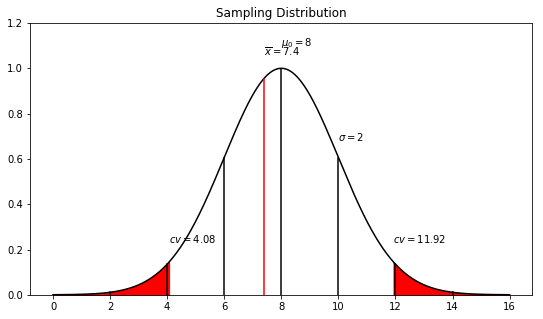

In [13]:
plotGauss(mu0, sigma, cv, mean, 'Sampling Distribution')

### One-sampled t-test
Is there a significant difference between a sample and a given population mean.

\begin{align} 
\overline{x} &= \frac{1}{n} \sum^n_{i=1}{x_i}
&&s = \sqrt{\frac{ \sum^n_{i=1}{(x_i - \overline{x})^2} }{n-1}} \\
s_e &= \frac{s}{\sqrt{n}}
&&t = \frac{  {\overline{x} - \mu_0}}{s_e}\\
d &= \frac{  {\overline{x} - \mu_0}}{s}
&&r^2 = \frac{t^2}{t^2+df}
\end{align}

In [14]:
# Descriptive statistics
sample = norm.rvs(loc=6, scale=2, size=15)
n, mean, sd = len(sample), np.mean(sample), np.std(sample)
print(mean, sd)
print(sample)

5.64847835334 1.92037405166
[ 5.12367037  5.85486435  5.70940596  3.34196663  5.64679265  6.22045809
  5.38667817  7.38992838  0.99972203  8.25664978  4.81663509  3.56881548
  6.57583843  7.00773859  8.82801129]


In [15]:
# Inferential statistics
mu0 = 5.5
cv = np.array(t.interval(.95, n-1)) # t.ppf(.05, 24) one-tailed
se = sd / np.sqrt(n)
T = (mean - mu0) / se
p = t.cdf(T, n-1)*2
print(T, p, cv)
print(ttest_1samp(sample, mu0))

0.299449052257 1.23100302405 [-2.14478669  2.14478669]
Ttest_1sampResult(statistic=0.28929526883630879, pvalue=0.77659531488707112)


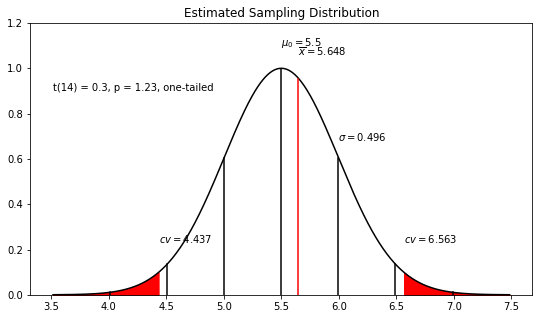

In [16]:
plotGauss(mu0, se, cv, mean, 'Estimated Sampling Distribution', apa(n-1, T, p, 'one-tailed'))

### Paired sampled t-test
Is there a significant difference between two dependent samples.

\begin{align}
x_i &= y_i - z_i\\
\overline{x} &= \frac{1}{n} \sum^n_{i=1}{x_i}
&&s = \sqrt{\frac{ \sum^n_{i=1}{(x_i - \overline{x})^2} }{n-1}} \\
s_e &= \frac{s}{\sqrt{n}}
&&t = \frac{  {\overline{x} - \mu_0}}{s_e}
\end{align}

In [17]:
# Descriptive statistics
sample1 = norm.rvs(loc=5.8, scale=2, size=15)
sample2 = norm.rvs(loc=6.1, scale=2, size=15)
sample = sample1 - sample2
n, mean, sd = len(sample), np.mean(sample), np.std(sample)
print(mean, sd)
print(sample)

0.171339525208 2.72694583528
[-2.50364216 -1.38002795 -1.8157835  -2.47211072  2.22087523 -0.44486713
  1.72172863 -0.55362849  5.83449117  2.45294113 -0.68061586  4.14702556
 -4.89984215 -0.91185302  1.85540214]


In [18]:
# Inferential statistics
mu0 = 0 # No difference
se = sd / np.sqrt(n-1)
T = (mean - mu0) / se
p = t.cdf(T, n-1)*2
cv = np.array(t.interval(.95, n -1))
print(T, p, cv)
print(ttest_rel(sample1, sample2))

0.235095905408 1.18246181268 [-2.14478669  2.14478669]
Ttest_relResult(statistic=0.2350959054075529, pvalue=0.81753818731588457)


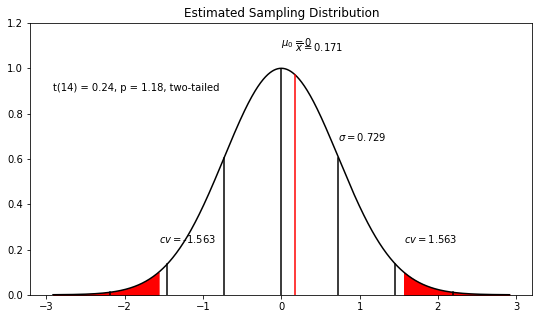

In [19]:
plotGauss(mu0, se, cv, mean, 'Estimated Sampling Distribution', apa(n-1, T, p, 'two-tailed'))

### Two sampled t-test
Is there a significant difference between independent samples.

\begin{align}
\overline{x} &= \frac{1}{n} \sum^n_{i=1}{x_i}
&&\overline{y} = \frac{1}{m} \sum^n_{i=1}{y_i}\\
s_x &= \sqrt{{\frac{ \sum^n_{i=1}{(x_i - \overline{x})^2} }{n-1}}} 
&& s_y = \sqrt{{\frac{ \sum^m_{i=1}{(y_i - \overline{y})^2} }{m-1}}} \\
s_p &= \sqrt{\frac{(n-1)s^2_x + (m-1)s^2_y}{n+m-2}}
&&s_e = s_p\sqrt{\frac{1}{n}+\frac{1}{m}}\\
s_e &= \sqrt{\frac{s_x^2}{n}+\frac{s_y^2}{m}}
&&t = \frac{  {\overline{x} - \overline{y}}} {s_e}
\end{align}

In [20]:
# Descriptive statistics
sample1 = norm.rvs(loc=5.8, scale=2, size=15)
sample2 = norm.rvs(loc=6.1, scale=2, size=10)
n, mean1, sd1 = len(sample1), np.mean(sample1), np.std(sample1)
m, mean2, sd2 = len(sample2), np.mean(sample2), np.std(sample2)
print(mean1, sd1, mean2, sd2)
print(sample1)
print(sample2)

6.63052448775 1.79969910071 5.19426471072 1.47818861158
[ 7.82003444  7.034856    5.94470453  3.90929078  6.55032281  2.91890751
  9.25235193  7.19787773  8.66192989  5.98586904  9.06324093  7.70197489
  6.36607072  6.94469455  4.10574157]
[ 7.74190494  2.45954776  5.12479089  3.93878738  3.87384193  4.97374074
  6.97210746  4.93450454  5.73596291  6.18745855]


In [21]:
# Inferential statistics
mu0 = 0
#sp = np.sqrt(((n-1) * np.power(sd1, 2) + (m-1) * np.power(sd2, 2)) / (n + m - 2))
#se = sp * np.sqrt((1/float(n)+1/float(m)))
se = np.sqrt((np.power(sd1, 2) / n) + (np.power(sd2, 2) / m))
T = (mean1 - mean2) / se
p = t.cdf(T, n+m-2)*2
cv = np.array(t.interval(.95, n + m - 2))
print(T, p, cv)
print(ttest_ind(sample1, sample2))

2.17907471102 1.96017603985 [-2.06865761  2.06865761]
Ttest_indResult(statistic=2.0103924530281665, pvalue=0.056257968227500718)


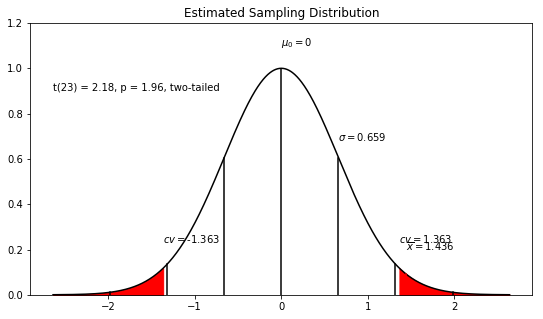

In [22]:
plotGauss(mu0, se, cv, mean1 - mean2, 'Estimated Sampling Distribution', apa(n+m-2, T, p, 'two-tailed'))

### Cohen's d and r squared

\begin{align}
s_p &= \sqrt{\frac{(n-1)s^2_x + (m-1)s^2_y}{n+m-2}}\\
d &= \frac{  {\overline{x} - \overline{y}}} {s_p}
&r^2 = \frac{t^2}{t^2+df}
\end{align}

## 3. Analysis of variance - Anova

In [23]:
from scipy.stats import f, f_oneway

Is there a significant difference between any two of more independent samples.

\begin{align}
F &= \frac{between\ group\ variability}{within\ group\ variablilty} 
= \frac{\sum^k_{k=1}{n_k(\overline{x}_k-\overline{x}_G)^2}\ /\ (k-1)}{\sum^k_{k=1}{(\overline{x}_i-\overline{x}_k)^2}\ /\ (N-k)}
= \frac{SS_{between}\ /\ df_{between}}{SS_{within}\ /\ df_{within}}
= \frac{MS_{between}}{MS_{within}}
\end{align}

Descriptive statistics

In [24]:
samples = np.array([norm.rvs(m, s, n) for (m, s, n) in [(2, 2, 100), (10, 5, 100), (30, 2, 100)]])
statistics = [(np.mean(sample), np.std(sample), len(sample)) for sample in samples]
statistics

[(1.6379797889871293, 1.9567641262188509, 100),
 (8.8056669569324075, 4.8115799515144468, 100),
 (30.178227458523143, 1.7512333710005634, 100)]

* As the between group variability increases, the F-statistic increases as well.
* As the within group variability increases, the F-statistic decreases.

|Sample 1   |Sample 2   |Sample k   | Grand mean  |
|--:|--:|--:|--:|
| $x_1$  | $x_1$  |$x_1$  |   |   
| $x_2$  | $x_2$  |$x_2$  |   |   
| $x_3$  | $x_3$  |$x_3$  |   |   
| $x_{n}$  | $x_{n}$  |$x_{n}$  |   |   
|  $\overline{x}_k$ | $\overline{x}_k$  | $\overline{x}_k$  | $\overline{x}_G$  |

Inferential statistics

In [25]:
grandMean = samples.flatten().mean()
sampleMeans = np.array([x[0] for x in statistics])
sampleSizes = np.array([x[2] for x in statistics])

In [26]:
ssb = np.sum(np.power(sampleMeans - grandMean, 2) * sampleSizes)
ssw = np.sum([np.power(np.array(xi)-xk, 2) for xi, xk in zip(samples, sampleMeans)])
dfb = len(sampleSizes) - 1
dfw = len(samples.flatten()) - len(sampleSizes)

In [27]:
F = (ssb / dfb) / (ssw / dfw)
p = f.sf(F, dfb, dfw)
print(F, p)
print(f_oneway(samples[0], samples[1], samples[2]))

2179.0507285 3.28740970319e-178
F_onewayResult(statistic=2179.0507284955033, pvalue=3.2874097031897022e-178)


Critical values, link to <a href="http://www.socr.ucla.edu/applets.dir/f_table.html">F-table</a>.

In [28]:
Fcrit = f.ppf(0.95, dfb, dfw)
print(Fcrit, 'Null hypothesis rejected?', F > Fcrit)

3.02615336857 Null hypothesis rejected? True


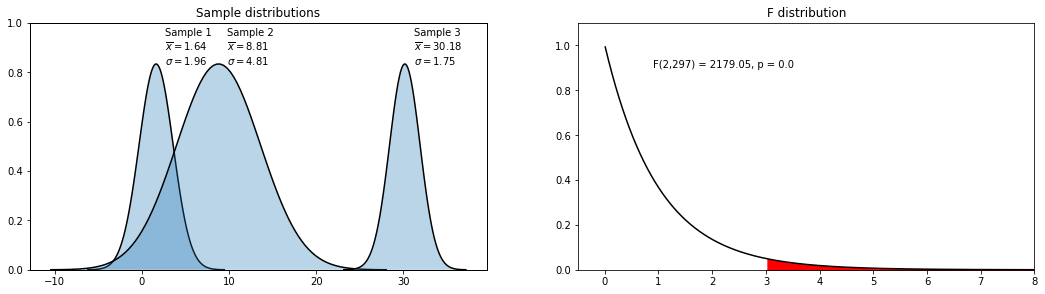

In [29]:
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)

for i, (m, s, n) in enumerate(statistics):
    ax = ax1.twinx()
    x = np.linspace(m-4*s, m+4*s, num=100)
    ax.plot(x, gauss(x, m, s), '-k')
    ax.fill_between(x, 0, gauss(x, m, s), alpha=0.3)
    ax.text(m+1, 1., 'Sample '+ str(i+1)+'\n' +
             r'$\overline{x} =$' + str(round(m, 2)) + '\n' + 
             r'$\sigma =$' + str(round(s, 2)))
    ax.set_ylim(0,1.2); ax.get_yaxis().set_visible(False)
ax1.set_title('Sample distributions')

x = np.linspace(0, 8, num=1000)
ax2.plot(x, f.pdf(x, dfb, dfw), '-k')
#ax2.fill_between(x, 0, f.pdf(x, dfb, dfw), alpha=0.2)
ax2.fill_between(x, 0, f.pdf(x, dfb, dfw), where=x>Fcrit, color='r')
ax2.axvline(x=F, color='r', ymax=f.pdf(F, dfb, dfw)*0.9)
ax2.set_ylim(0,1.1); ax2.set_xlim(-.5,8)
ax2.set_title('F distribution')

s = 'F('+ str(dfb)+','+str(dfw)+') = ' + str(round(F, 2)) + ', p = ' + str(round(p, 2))
ax2.text(0.9, 0.9, s)

plt.show()

### Multiple Comparison Test - Tuckey's HSD

\begin{align}
Tuckey's\ HSD = q\ \sqrt{\frac{MS_{within}}{n}}
= q\ \frac{s_p}{\sqrt{n}}
\end{align}

Critical values, link to [Q-table](https://www2.stat.duke.edu/courses/Spring98/sta110c/qtable.html). If mean differences exceeds critical value, variables are honestly significantly different.

In [30]:
msw = ssw / dfw
hsd = 3.34* np.sqrt(msw / sampleSizes[0])
hsd

1.0623536921610128

In [31]:
print(sampleMeans[2] - sampleMeans[1])
print(sampleMeans[2] - sampleMeans[0])
print(sampleMeans[1] - sampleMeans[0])

21.3725605016
28.5402476695
7.16768716795


### Cohen's d and $\eta$ squared test

\begin{align}
d &= \frac{  {\overline{x} - \overline{y}}} {\sqrt{{MS_{within}}}} = \frac{  {\overline{x} - \overline{y}}} {s_p}\\\\
\eta &= \frac{SS_{between}}{SS_{between} + SS_{within}}
\end{align}

In [32]:
den = np.sqrt(ssw / dfw)
d1 = (sampleMeans[2] - sampleMeans[1]) / den
d2 = (sampleMeans[2] - sampleMeans[0]) / den
d3 = (sampleMeans[1] - sampleMeans[0]) / den
print(d1, d2, d3)

6.71945253281 8.97294638496 2.25349385215


In [33]:
eta = ssb / (ssb + ssw)
print(eta)

0.936199027509


## 4. Correlation

In [34]:
from scipy.stats import pearsonr, t

$r^2$ is the percentage of the variation in $y$ explained by the variation in $x$. 

$t$ is used in a t-test to verify whether $\rho$ (the estimated population correlation) expresses correlation.

\begin{align}
r &= \frac{Cov\ (x,y)}{s_x\ s_y}
= \frac{\sum_{i=1}^n{(x_i - \overline{x})(y_i - \overline{y})\ /\ (n - 1)}}{{s_x\ s_y}} \\\\
t &= \frac{r\sqrt{df}}{1 - r^2} &df = n-2
\end{align}

Descriptive statistics

In [35]:
sample1 = norm.rvs(10, 2, 200)
sample2 = (sample1 + norm.rvs(0, 1.5, 200)) * -10
n, mean1, sd1 = len(sample1), np.mean(sample1), np.std(sample1)
m, mean2, sd2 = len(sample2), np.mean(sample2), np.std(sample2)
print(mean1, sd1)
print(mean2, sd2)

10.0957284993 2.13129812643
-98.5351328676 27.1553980592


Inferential statistics

In [36]:
r = (((sample1 - mean1) * (sample2 - mean2)).sum() / (n - 1)) / (sd1 * sd2)
r = (n * (sample1*sample2).sum() - sample1.sum()*sample2.sum()) / np.sqrt((n*np.power(sample1, 2).sum() - np.power(sample1.sum(), 2)) * (n*np.power(sample2, 2).sum() - np.power(sample2.sum(), 2)))
T = (r * np.sqrt(n-2)) / (1 - np.power(r, 2))
p = t.sf(T, n-1)
slope = r * sd2 / sd1
intercept = mean2 - slope * mean1
print(r, T, p)
print(pearsonr(sample1, sample2))
print(slope, intercept)

-0.825395756672 -36.440388328 1.0
(-0.82539575667240039, 4.711487468179963e-51)
-10.5165720604 7.63732339779


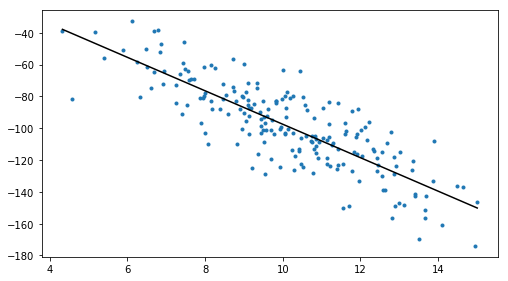

In [37]:
fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(221)
ax.scatter(sample1, sample2, marker='.')
x = np.linspace(min(sample1), max(sample1), num=1000)
ax.plot(x, slope * x + intercept, color='k')
plt.show()